In [1]:
import argparse
import os
import torch
import pyro
import json
import math
from tqdm import tqdm
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import PyroOptim
from torch.optim import Adam
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap
from scipy.sparse import csr_matrix
from scipy.spatial import KDTree
import seaborn as sns

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import lightning as L
import torch.nn.functional as F
from torch.utils.data import DataLoader

import subprocess
import warnings
warnings.filterwarnings("ignore")
from importlib import reload

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
if torch.cuda.is_available():
    print("YAY! GPU available :3")
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

YAY! GPU available :3


In [3]:
def prepare_DLPFC_data(
    section_id=151670,
    num_pcs=5,
    log_normalize=True,
):
    section = ad.read_h5ad(f"data/DLPFC/{section_id}.h5ad")
    section.var["feature_name"] = section.var.index

    spatial_locations = section.obs[["array_row", "array_col"]]
    spatial_locations.columns = ["row", "col"]

    clustering = XeniumCluster(data=section.X, dataset_name="DLPFC")
    clustering.xenium_spot_data = section
    if log_normalize:
        clustering.xenium_spot_data.X = np.log1p(clustering.xenium_spot_data.X)

    sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack', n_comps=num_pcs)
    data = clustering.xenium_spot_data.obsm["X_pca"]

    return data, spatial_locations, clustering

def prepare_Xenium_data(
        dataset="hBreast", 
        spots=True, 
        spot_size=100, 
        third_dim=False, 
        log_normalize=True,
        likelihood_mode="PCA",
        num_pcs=5,
        hvg_var_prop=0.5,
        min_expressions_per_spot=10
    ):

    data_filepath = f"data/spot_data/{dataset}/hBreast_SPOTSIZE={spot_size}um_z={third_dim}.h5ad"
    
    if spots:

        if os.path.exists(data_filepath):

            clustering = XeniumCluster(data=None, dataset_name="hBreast")
            clustering.set_spot_size(spot_size)
            print("Loading data.")
            clustering.xenium_spot_data = ad.read_h5ad(data_filepath)

        else:

            # Path to your .gz file
            file_path = f'data/{dataset}/transcripts.csv.gz'

            # Read the gzipped CSV file into a DataFrame
            df_transcripts = pd.read_csv(file_path, compression='gzip')
            df_transcripts["error_prob"] = 10 ** (-df_transcripts["qv"]/10)
            df_transcripts.head(), df_transcripts.shape

            # drop cells without ids
            df_transcripts = df_transcripts[df_transcripts["cell_id"] != -1]

            # drop blanks and controls
            df_transcripts = df_transcripts[~df_transcripts["feature_name"].str.startswith('BLANK_') & ~df_transcripts["feature_name"].str.startswith('NegControl')]

            clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
            clustering.set_spot_size(spot_size)

            if not os.path.exists(data_filepath):
                print("Generating and saving data")
                clustering.create_spot_data(third_dim=third_dim, save_data=True)
                clustering.xenium_spot_data.write_h5ad(data_filepath)

        print("Number of spots: ", clustering.xenium_spot_data.shape[0])
        clustering.xenium_spot_data = clustering.xenium_spot_data[clustering.xenium_spot_data.X.sum(axis=1) > min_expressions_per_spot]
        print("Number of spots after filtering: ", clustering.xenium_spot_data.shape[0])

        if log_normalize:
            clustering.normalize_counts(clustering.xenium_spot_data)

        if likelihood_mode == "PCA":
            sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack', n_comps=num_pcs)
            data = clustering.xenium_spot_data.obsm["X_pca"]
        elif likelihood_mode == "HVG":
            min_dispersion = torch.distributions.normal.Normal(0.0, 1.0).icdf(hvg_var_prop)
            clustering.filter_only_high_variable_genes(clustering.xenium_spot_data, flavor="seurat", min_mean=0.0125, max_mean=1000, min_disp=min_dispersion)
            clustering.xenium_spot_data = clustering.xenium_spot_data[:,clustering.xenium_spot_data.var.highly_variable==True]
            data = clustering.xenium_spot_data.X
        elif likelihood_mode == "ALL":
            data = clustering.xenium_spot_data.X

        spatial_locations = clustering.xenium_spot_data.obs[["row", "col"]]
    
    # prepare cells data
    else:

        cells = df_transcripts.groupby(['cell_id', 'feature_name']).size().reset_index(name='count')
        cells_pivot = cells.pivot_table(index='cell_id', 
                                        columns='feature_name', 
                                        values='count', 
                                        fill_value=0)
        
        location_means = df_transcripts.groupby('cell_id').agg({
            'x_location': 'mean',
            'y_location': 'mean',
            'z_location': 'mean'
        }).reset_index()

        cells_pivot = location_means.join(cells_pivot, on='cell_id')

        if log_normalize:
            # log normalization
            cells_pivot.iloc[:, 4:] = np.log1p(cells_pivot.iloc[:, 4:])

        if likelihood_mode == "PCA":
            pca = PCA(n_components=num_pcs)
            data = pca.fit_transform(cells_pivot.iloc[:, 4:])

        elif likelihood_mode == "HVG":
            genes = cells_pivot.iloc[:, 4:]
            gene_variances = genes.var(axis=0)
            gene_variances = gene_variances.sort_values(ascending=False)
            gene_var_proportions = (gene_variances / sum(gene_variances))
            relevant_genes = list(gene_var_proportions[(gene_var_proportions.cumsum() < hvg_var_prop)].index)
            cells_pivot.iloc[:, 4:] = cells_pivot.iloc[:, 4:][[relevant_genes]]
            data = cells_pivot.iloc[:, 4:]

        elif likelihood_mode == "ALL":
            data = cells_pivot.iloc[:, 4:]

        spatial_locations = cells_pivot[["x_location", "y_location"]]


    return data, spatial_locations, clustering # the last one is to regain var/obs access from original data

In [4]:
spot_size=50
data_mode="PCA"
num_pcs=5
hvg_var_prop=0.5
dataset_name="hBreast"
kmeans_init=True
custom_init="Leiden"
spatial_init=True
num_clusters=17
batch_size=512
neighborhood_size=1
neighborhood_agg="mean"
concentration_amplification=3
uncertainty_values = [1/num_clusters, 2/num_clusters, 3/num_clusters, 4/num_clusters, 5/num_clusters]
evaluate_markers=False
spatial_normalize=0.00

In [5]:
gene_data, spatial_locations, original_adata = prepare_Xenium_data(
    dataset="hBreast", 
    spots=True, 
    spot_size=spot_size, 
    third_dim=False, 
    log_normalize=True, 
    likelihood_mode=data_mode, 
    num_pcs=num_pcs,
    hvg_var_prop=hvg_var_prop,
    min_expressions_per_spot=0
)

Loading data.
Number of spots:  23444
Number of spots after filtering:  23444


In [6]:
original_adata.xenium_spot_data

AnnData object with n_obs × n_vars = 23444 × 280
    obs: 'spot_number', 'x_location', 'y_location', 'z_location', 'row', 'col'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw'

In [8]:
original_adata.xenium_spot_data.obs

,spot_number,x_location,y_location,z_location,row,col
0,43,548.426080,2218.907850,12.599341,43.0,0.0
1,45,550.663970,2337.095433,19.034785,45.0,0.0
2,46,552.062194,2358.384500,16.009149,46.0,0.0
3,47,551.965956,2423.005319,16.599941,47.0,0.0
4,48,546.802622,2483.570972,15.898581,48.0,0.0
...,...,...,...,...,...,...
23439,33366,10015.713547,5868.944360,27.402354,116.0,190.0
23440,33367,10018.078500,5910.929274,27.193971,117.0,190.0
23441,33368,10017.667292,5977.355553,27.780879,118.0,190.0
23442,33369,10015.040000,6039.822000,30.913712,119.0,190.0


In [9]:
def save_filepath(model, component, sample_for_assignment=None):

    total_file_path = (
        f"results/{dataset_name}/{model}/{component}/{data_file_path}/"
        f"INIT={custom_init}/NEIGHBORSIZE={neighborhood_size}/NUMCLUSTERS={num_clusters}"
        f"/SPATIALINIT={spatial_init}/SAMPLEFORASSIGNMENT={sample_for_assignment}"
        f"/SPATIALNORM={spatial_normalize}/SPATIALPRIORMULT={concentration_amplification}/SPOTSIZE={spot_size}/AGG={neighborhood_agg}"
    )

    return total_file_path

In [10]:
def custom_cluster_initialization(original_adata, method, K=17):

    original_adata.generate_neighborhood_graph(original_adata.xenium_spot_data, plot_pcas=False)

    # This function initializes clusters based on the specified method
    if method == "K-Means":
        initial_clusters = original_adata.KMeans(original_adata.xenium_spot_data, save_plot=True, K=K, include_spatial=False)
    elif method == "Hierarchical":
        initial_clusters = original_adata.Hierarchical(original_adata.xenium_spot_data, save_plot=True, K=K)
    elif method == "Leiden":
        initial_clusters = original_adata.Leiden(original_adata.xenium_spot_data, resolutions=[0.75], save_plot=True, K=K)[0.75]
    elif method == "Louvain":
        initial_clusters = original_adata.Louvain(original_adata.xenium_spot_data, resolutions=[1.0], save_plot=True, K=K)[1.0]
    else:
        raise ValueError(f"Unknown method: {method}")

    return initial_clusters

Batch Size is 512.


100%|██████████| 23444/23444 [00:01<00:00, 15191.88it/s]


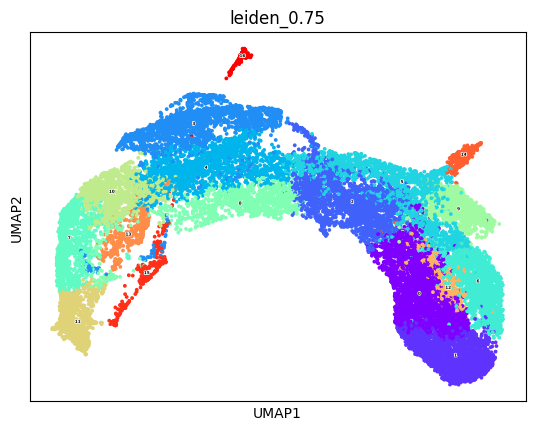

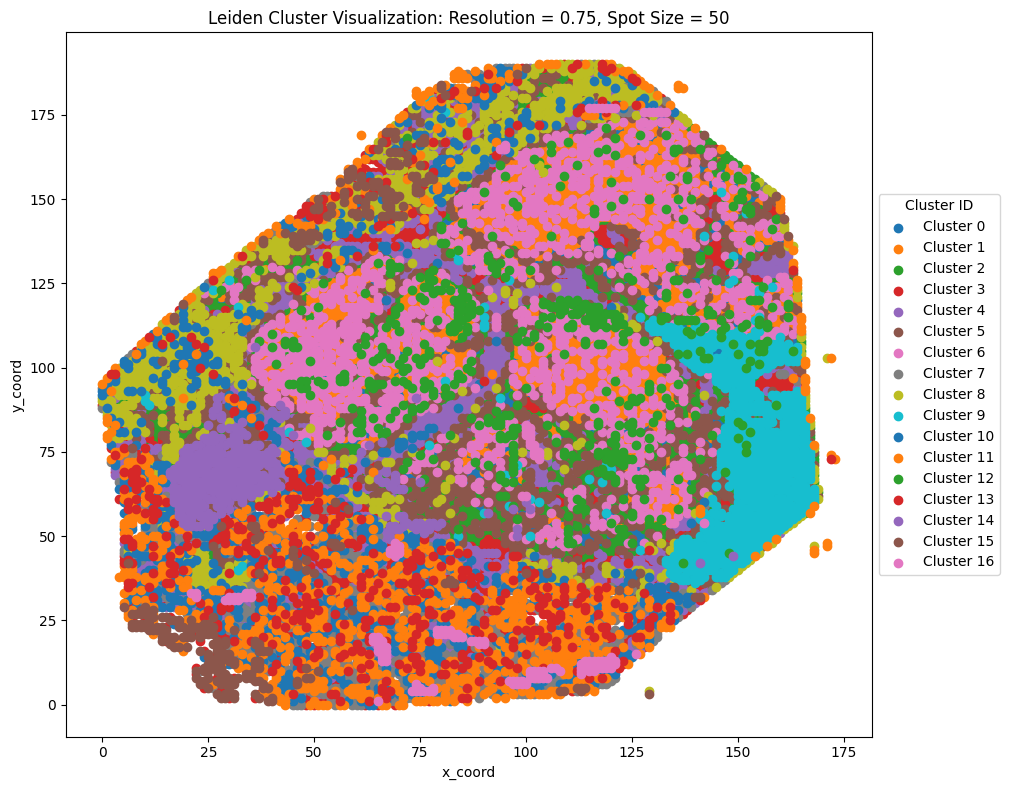

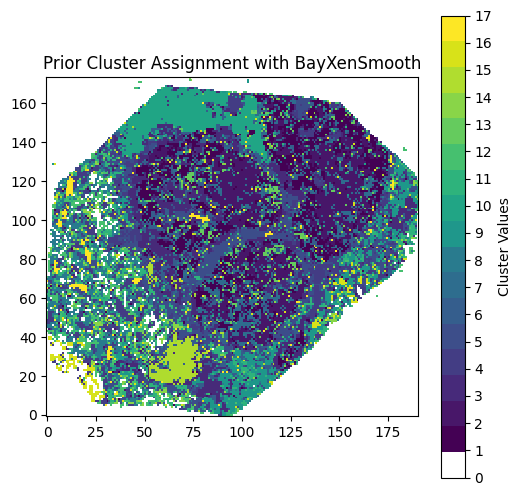

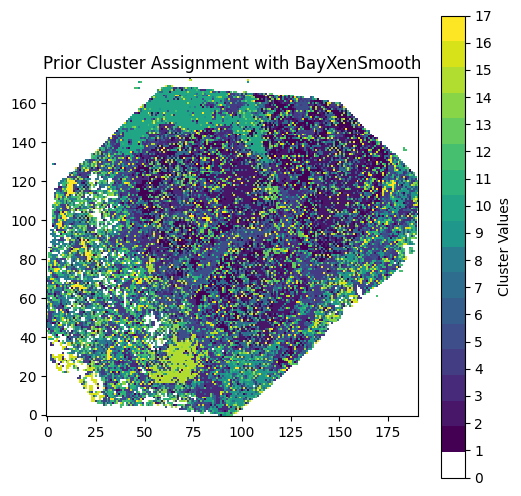

In [11]:
print(f"Batch Size is {batch_size}.")

# Clamping
MIN_CONCENTRATION = 0.1

spatial_init_data = StandardScaler().fit_transform(gene_data)
gene_data = StandardScaler().fit_transform(gene_data)
empirical_prior_means = torch.ones(num_clusters, spatial_init_data.shape[1])
empirical_prior_scales = torch.ones(num_clusters, spatial_init_data.shape[1])

rows = spatial_locations["row"].astype(int)
columns = spatial_locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

if custom_init or kmeans_init:

    if custom_init:

        initial_clusters = custom_cluster_initialization(original_adata, custom_init)
        concentration_priors = torch.tensor(pd.get_dummies(initial_clusters, dtype=float).to_numpy())

    elif kmeans_init:

        kmeans_init_data = np.concatenate((spatial_locations, original_adata.xenium_spot_data.X), axis=1)
        kmeans_init_data = StandardScaler().fit_transform(kmeans_init_data)

        if spatial_normalize:

            spatial_dim = spatial_locations.shape[1]
            gene_dim = original_adata.xenium_spot_data.X.shape[1]
            spatial_factor = (gene_dim * spatial_normalize / (spatial_dim * (1 - spatial_normalize))) ** 0.5
            kmeans_init_data[:, :spatial_locations.shape[1]] *= spatial_factor

        kmeans = KMeans(n_clusters=num_clusters).fit(kmeans_init_data)

        initial_clusters = kmeans.predict(kmeans_init_data)

        for i in range(num_clusters):
            empirical_prior_means[i] = torch.tensor(gene_data[initial_clusters == i].mean(axis=0))
            empirical_prior_scales[i] = torch.tensor(gene_data[initial_clusters == i].std(axis=0))

    match data_mode:
        case "PCA":
            data_file_path = f"{data_mode}/{num_pcs}"
        case "HVG": 
            data_file_path = f"{data_mode}/{hvg_var_prop}"
        case "ALL":
            data_file_path = f"{data_mode}"
        case _:
            raise ValueError("The data mode specified is not supported.")
        
    if kmeans_init and not custom_init:

        if not os.path.exists(kmeans_clusters_filepath := save_filepath("KMeans", "clusters")):
            os.makedirs(kmeans_clusters_filepath)
        _ = plt.savefig(
            f"{kmeans_clusters_filepath}/result.png"
        )

        cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.int)
        
        cluster_grid[rows, columns] = torch.tensor(initial_clusters, dtype=torch.int) + 1

        colors = plt.cm.get_cmap('viridis', num_clusters + 1)
        colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_grid.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
        plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
        plt.title('Cluster Assignment with KMeans')

    if dataset_name == "DLPFC":
        # Create a DataFrame for easier handling
        data = pd.DataFrame({
            'ClusterAssignments': initial_clusters,
            'Region': original_adata.xenium_spot_data.obs["Region"]
        })

        # Drop rows where 'Region' is NaN
        filtered_data = data.dropna(subset=['Region'])

        # Calculate ARI and NMI only for the non-NaN entries
        ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        cluster_metrics = {
            "ARI": ari,
            "NMI": nmi
        }

        data_file_path = f"{data_mode}/{num_pcs}"

        if not os.path.exists(kmeans_cluster_metrics_filepath := save_filepath("KMeans", "cluster_metrics")):
            os.makedirs(kmeans_cluster_metrics_filepath)
        with open(f"{kmeans_cluster_metrics_filepath}/wss.json", 'w') as fp:
            json.dump(cluster_metrics, fp)

    concentration_priors = torch.tensor(pd.get_dummies(initial_clusters, dtype=float).to_numpy())

else:

    concentration_priors = torch.ones((len(gene_data), num_clusters), dtype=float)

concentration_w_locations = torch.cat((torch.tensor(spatial_locations.to_numpy()), concentration_priors), dim=1)

# Clone to avoid modifying the original tensor
spatial_concentration_priors = concentration_priors.clone()

# Compute the number of elements in each dimension
num_spots = concentration_priors.shape[0]

# Initialize an empty tensor for spatial concentration priors
spatial_concentration_priors =  spatial_concentration_priors = torch.zeros_like(concentration_priors, dtype=torch.float64)

spot_locations = KDTree(concentration_w_locations[:, :2].cpu())  # Ensure this tensor is in host memory
neighboring_spot_indexes = spot_locations.query_ball_point(concentration_w_locations[:, :2].cpu(), r=neighborhood_size, p=1, workers=8)

# Iterate over each spot
for i in tqdm(range(num_spots)):

    # Select priors in the neighborhood
    priors_in_neighborhood = concentration_priors[neighboring_spot_indexes[i]]
    # print(f"Spot {i} has {len(neighboring_spot_indexes[i])} neighbors")
    # print(priors_in_neighborhood)

    # Compute the sum or mean, or apply a custom weighting function
    if neighborhood_agg == "sum":
        neighborhood_expression = priors_in_neighborhood.sum(dim=0)
    elif neighborhood_agg == "mean":
        neighborhood_expression = priors_in_neighborhood.mean(dim=0)
    else:
        locations = original_adata.xenium_spot_data.obs[["x_location", "y_location", "z_location"]].values
        neighboring_locations = locations[neighboring_spot_indexes[i]].astype(float)
        distances = torch.tensor(np.linalg.norm(neighboring_locations - locations[i], axis=1))
        def distance_weighting(x):
            weight = 1/(1 + x/spot_size)
            # print(weight)
            return weight
        neighborhood_expression = (priors_in_neighborhood * distance_weighting(distances).reshape(-1, 1)).sum(dim=0)
    # Update spatial concentration priors with the computed neighborhood expression
    # print(neighborhood_expression)
    spatial_concentration_priors[i] += neighborhood_expression

# Normalize concentration priors
concentration_priors = torch.tensor(spatial_concentration_priors, dtype=torch.float64)
concentration_priors += torch.distributions.half_normal.HalfNormal(0.25).sample(concentration_priors.shape)
concentration_priors /= concentration_priors.sum(dim=1, keepdim=True)
concentration_priors *= num_clusters * concentration_amplification

# for val in concentration_priors:
#     print(val)

sample_for_assignment_options = [False, True]

for sample_for_assignment in sample_for_assignment_options:

    if sample_for_assignment:
        cluster_probs_prior_TRUE = dist.Dirichlet(concentration_priors).sample()
        cluster_assignments_prior = cluster_probs_prior_TRUE.argmax(dim=1)  
    else:
        # the probs aren't sampled and we calculate the EV instead
        cluster_probs_prior_FALSE = (concentration_priors / concentration_priors.sum(dim=1, keepdim=True))
        cluster_assignments_prior = cluster_probs_prior_FALSE.argmax(dim=1)

    # Load the data
    data = torch.tensor(gene_data).float()

    cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

    cluster_grid[rows, columns] = cluster_assignments_prior + 1

    colors = plt.cm.get_cmap('viridis', num_clusters + 1)
    
    colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
    colormap = ListedColormap(colormap_colors)

    plt.figure(figsize=(6, 6))
    plt.imshow(cluster_grid.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
    plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
    plt.title('Prior Cluster Assignment with BayXenSmooth')

    if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
        os.makedirs(bayxensmooth_clusters_filepath)
    _ = plt.savefig(
        f"{bayxensmooth_clusters_filepath}/prior_result.png"
    )

In [12]:
def model(data):

    # Define the means and variances of the Gaussian components
    cluster_means = pyro.sample("cluster_means", dist.Normal(empirical_prior_means, 1.0).to_event(2))
    cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(empirical_prior_scales, 1.0).to_event(2))

    # Define priors for the cluster assignment probabilities and Gaussian parameters
    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:
        batch_data = data[ind]
        batch_concentration_priors = concentration_priors[ind]
        cluster_probs = pyro.sample("cluster_probs", dist.Dirichlet(batch_concentration_priors))
        # Likelihood of data given cluster assignments
        for i in range(cluster_probs.size(0)):
            pyro.sample(f"obs_{i}", dist.MixtureOfDiagNormals(cluster_means, cluster_scales, cluster_probs[i]), obs=batch_data[i])

def guide(data):
    # Initialize cluster assignment probabilities for the entire dataset
    cluster_concentration_params_q = pyro.param("cluster_concentration_params_q", concentration_priors, constraint=dist.constraints.positive).clamp(min=MIN_CONCENTRATION)
    # Global variational parameters for means and scales
    cluster_means_q = pyro.param("cluster_means_q", empirical_prior_means)
    cluster_scales_q = pyro.param("cluster_scales_q", empirical_prior_scales, constraint=dist.constraints.positive)
    cluster_means = pyro.sample("cluster_means", dist.Normal(cluster_means_q, 1.0).to_event(2))
    cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(cluster_scales_q, 1.0).to_event(2))
    
    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:

        batch_cluster_concentration_params_q = cluster_concentration_params_q[ind].clamp(min=MIN_CONCENTRATION)
        cluster_probs = pyro.sample("cluster_probs", dist.Dirichlet(batch_cluster_concentration_params_q))

In [13]:
NUM_EPOCHS = 40
NUM_BATCHES = int(math.ceil(data.shape[0] / batch_size))

# Setup the optimizer
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
scheduler = PyroOptim(Adam, adam_params)

# Setup the inference algorithm
svi = SVI(model, guide, scheduler, loss=TraceMeanField_ELBO(num_particles=25, vectorize_particles=True))

# Create a DataLoader for the data
# Convert data to CUDA tensors before creating the DataLoader
data = data.to('cuda')

# Clear the param store in case we're in a REPL
pyro.clear_param_store()

epoch_pbar = tqdm(range(NUM_EPOCHS))
for epoch in epoch_pbar:
    epoch_pbar.set_description(f"Epoch {epoch}")
    running_loss = 0.0
    for step in range(NUM_BATCHES):
        loss = svi.step(data)
        running_loss += loss / batch_size
    # svi.optim.step()
    if epoch % 1 == 0:
        print(f"Epoch {epoch} : loss = {round(running_loss/1e6, 4)}")
        # cluster_concentration_params_q = pyro.param("cluster_concentration_params_q", concentration_priors, constraint=dist.constraints.positive).clamp(min=MIN_CONCENTRATION)
        # if sample_for_assignment:
        #     cluster_probs_q = pyro.sample("cluster_probs", dist.Dirichlet(cluster_concentration_params_q, validate_args=True)).detach()     
        # else:
        #     # the probs aren't sampled and we calculate the EV instead
        #     cluster_probs_q = (cluster_concentration_params_q / cluster_concentration_params_q.sum(dim=1, keepdim=True))
        # cluster_assignments_q = cluster_probs_q.argmax(dim=1)

        # if dataset_name == "DLPFC":
        #     # Create a DataFrame for easier handling
        #     cluster_data = pd.DataFrame({
        #         'ClusterAssignments': cluster_assignments_q,
        #         'Region': original_adata.xenium_spot_data.obs["Region"]
        #     })

        #     # Drop rows where 'Region' is NaN
        #     filtered_data = cluster_data.dropna(subset=['Region'])

        #     # Calculate ARI and NMI only for the non-NaN entries
        #     ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        #     nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        #     print(f"Step {step} : ARI = {ari} NMI = {nmi}")

Epoch 1:   2%|▎         | 1/40 [00:04<02:51,  4.40s/it]

Epoch 0 : loss = 0.5767


Epoch 2:   5%|▌         | 2/40 [00:07<02:17,  3.63s/it]

Epoch 1 : loss = 0.5715


Epoch 3:   8%|▊         | 3/40 [00:10<02:04,  3.37s/it]

Epoch 2 : loss = 0.566


Epoch 4:  10%|█         | 4/40 [00:13<01:57,  3.27s/it]

Epoch 3 : loss = 0.5567


Epoch 5:  12%|█▎        | 5/40 [00:16<01:52,  3.21s/it]

Epoch 4 : loss = 0.5551


Epoch 6:  15%|█▌        | 6/40 [00:19<01:47,  3.17s/it]

Epoch 5 : loss = 0.5482


Epoch 7:  18%|█▊        | 7/40 [00:22<01:43,  3.14s/it]

Epoch 6 : loss = 0.5446


Epoch 8:  20%|██        | 8/40 [00:26<01:40,  3.13s/it]

Epoch 7 : loss = 0.5391


Epoch 9:  22%|██▎       | 9/40 [00:29<01:36,  3.12s/it]

Epoch 8 : loss = 0.5342


Epoch 10:  25%|██▌       | 10/40 [00:32<01:33,  3.11s/it]

Epoch 9 : loss = 0.5316


Epoch 11:  28%|██▊       | 11/40 [00:35<01:30,  3.12s/it]

Epoch 10 : loss = 0.527


Epoch 12:  30%|███       | 12/40 [00:38<01:27,  3.11s/it]

Epoch 11 : loss = 0.5204


Epoch 13:  32%|███▎      | 13/40 [00:41<01:23,  3.11s/it]

Epoch 12 : loss = 0.519


Epoch 14:  35%|███▌      | 14/40 [00:44<01:20,  3.10s/it]

Epoch 13 : loss = 0.5167


Epoch 15:  38%|███▊      | 15/40 [00:48<01:19,  3.19s/it]

Epoch 14 : loss = 0.5133


Epoch 16:  40%|████      | 16/40 [00:51<01:16,  3.17s/it]

Epoch 15 : loss = 0.5112


Epoch 17:  42%|████▎     | 17/40 [00:54<01:12,  3.15s/it]

Epoch 16 : loss = 0.5097


Epoch 18:  45%|████▌     | 18/40 [00:57<01:08,  3.14s/it]

Epoch 17 : loss = 0.5046


Epoch 19:  48%|████▊     | 19/40 [01:00<01:05,  3.13s/it]

Epoch 18 : loss = 0.5044


Epoch 20:  50%|█████     | 20/40 [01:03<01:02,  3.12s/it]

Epoch 19 : loss = 0.5013


Epoch 21:  52%|█████▎    | 21/40 [01:06<00:59,  3.13s/it]

Epoch 20 : loss = 0.5009


Epoch 22:  55%|█████▌    | 22/40 [01:09<00:56,  3.12s/it]

Epoch 21 : loss = 0.4977


Epoch 23:  57%|█████▊    | 23/40 [01:12<00:53,  3.12s/it]

Epoch 22 : loss = 0.4975


Epoch 24:  60%|██████    | 24/40 [01:16<00:49,  3.12s/it]

Epoch 23 : loss = 0.4928


Epoch 25:  62%|██████▎   | 25/40 [01:19<00:46,  3.12s/it]

Epoch 24 : loss = 0.4922


Epoch 26:  65%|██████▌   | 26/40 [01:22<00:43,  3.12s/it]

Epoch 25 : loss = 0.4924


Epoch 27:  68%|██████▊   | 27/40 [01:25<00:40,  3.12s/it]

Epoch 26 : loss = 0.4914


Epoch 28:  70%|███████   | 28/40 [01:28<00:37,  3.11s/it]

Epoch 27 : loss = 0.4889


Epoch 29:  72%|███████▎  | 29/40 [01:31<00:34,  3.11s/it]

Epoch 28 : loss = 0.4853


Epoch 30:  75%|███████▌  | 30/40 [01:34<00:31,  3.10s/it]

Epoch 29 : loss = 0.4857


Epoch 31:  78%|███████▊  | 31/40 [01:37<00:27,  3.10s/it]

Epoch 30 : loss = 0.4834


Epoch 32:  80%|████████  | 32/40 [01:40<00:24,  3.11s/it]

Epoch 31 : loss = 0.4836


Epoch 33:  82%|████████▎ | 33/40 [01:44<00:21,  3.11s/it]

Epoch 32 : loss = 0.4857


Epoch 34:  85%|████████▌ | 34/40 [01:47<00:18,  3.12s/it]

Epoch 33 : loss = 0.4824


Epoch 35:  88%|████████▊ | 35/40 [01:50<00:15,  3.12s/it]

Epoch 34 : loss = 0.4828


Epoch 36:  90%|█████████ | 36/40 [01:53<00:12,  3.13s/it]

Epoch 35 : loss = 0.4801


Epoch 37:  92%|█████████▎| 37/40 [01:56<00:09,  3.23s/it]

Epoch 36 : loss = 0.4797


Epoch 38:  95%|█████████▌| 38/40 [02:00<00:06,  3.32s/it]

Epoch 37 : loss = 0.4817


Epoch 39:  98%|█████████▊| 39/40 [02:03<00:03,  3.35s/it]

Epoch 38 : loss = 0.4776


Epoch 39: 100%|██████████| 40/40 [02:07<00:00,  3.18s/it]

Epoch 39 : loss = 0.4783


Loading data.
Number of spots:  23444
Number of spots after filtering:  23444
BXS MORAN False
Starting Moran's I Calculation.
Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 1.1444272264293307
100 CEACAM6 0.33916979364095023
100 FASN 0.9779334221336193
100 FGL2 0.4839378901373159
100 IL7R 0.8271267639865245
100 KRT6B 0.7386620267720425
100 POSTN 0.5361369794003464
100 TCIM 0.6787500446688809
{'BANK1': 1.1444272264293307, 'CEACAM6': 0.33916979364095023, 'FASN': 0.9779334221336193, 'FGL2': 0.4839378901373159, 'IL7R': 0.8271267639865245, 'KRT6B': 0.7386620267720425, 'POSTN': 0.5361369794003464, 'TCIM': 0.6787500446688809}
INITIAL MORAN False
Starting Moran's I Calculation.
Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 1.4037311358957485
100 CEACAM6 0.34268642712822245
100 FASN 0.9954958796901465
100 FGL2 0.5635590729345209
100 IL7R 1.0066273416797875
100 KRT6B 0.9076516924788193
100 POSTN 0.6150417644630521
100 TC

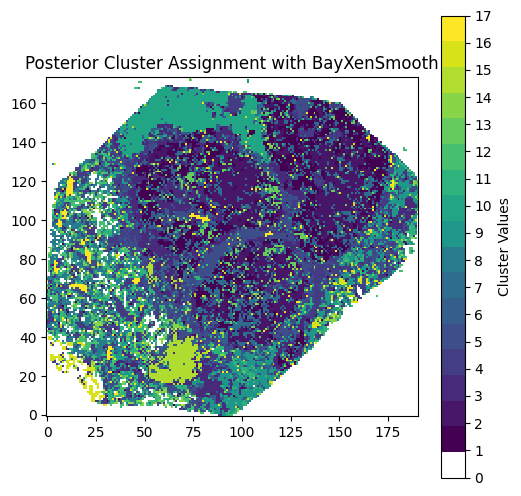

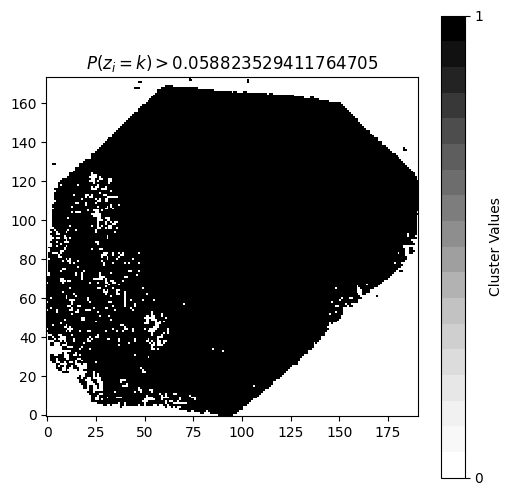

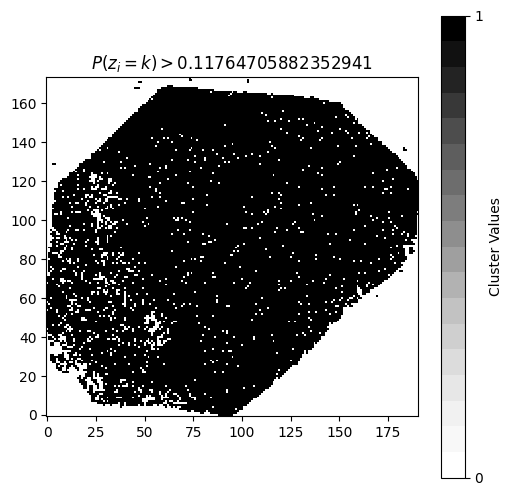

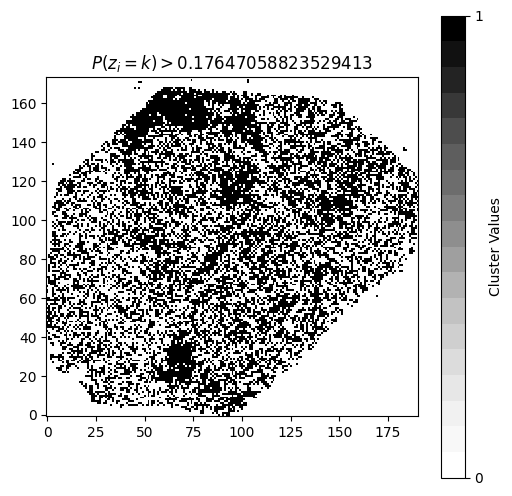

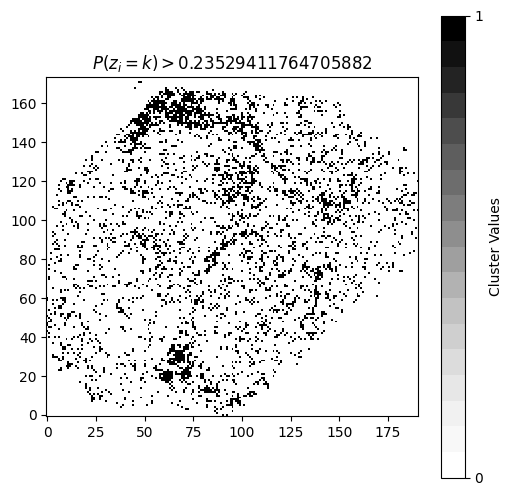

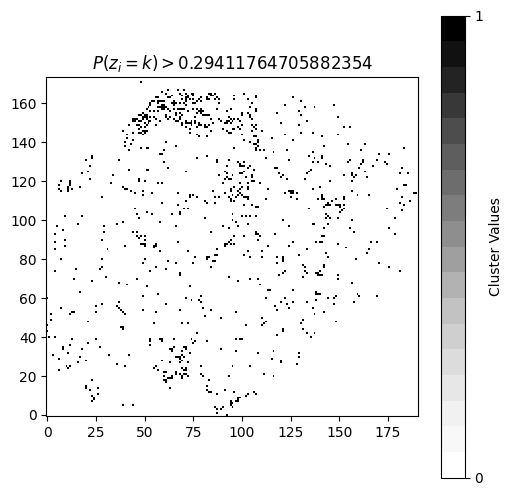

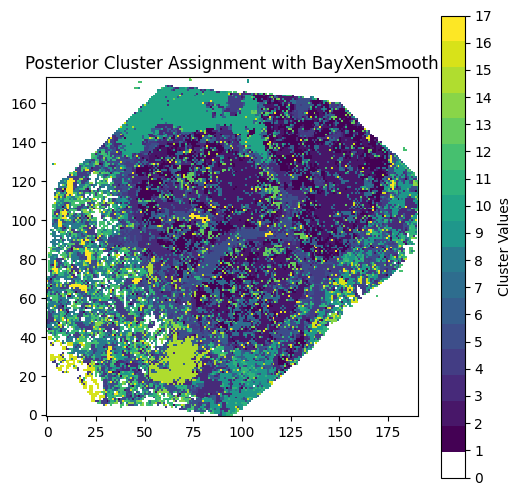

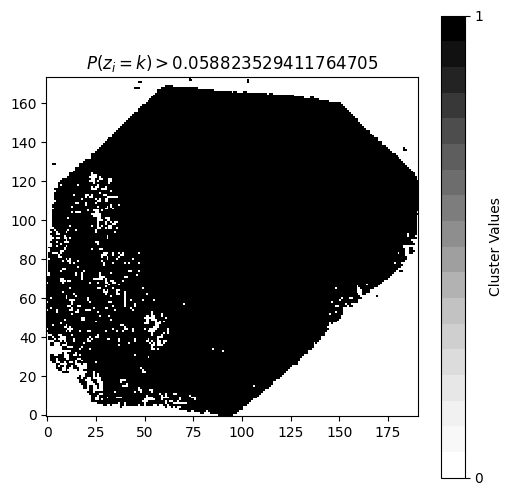

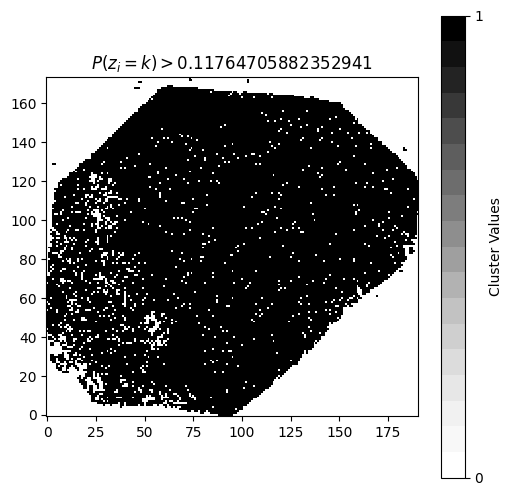

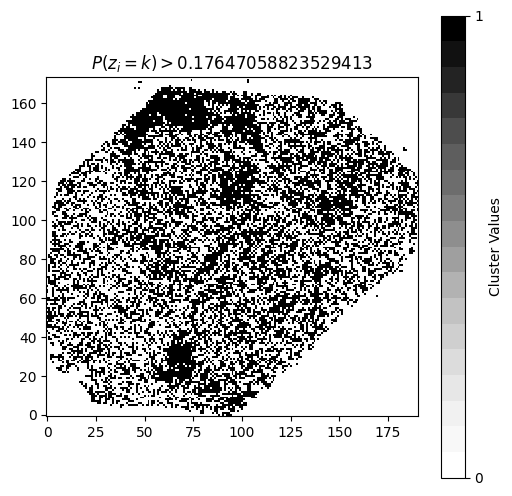

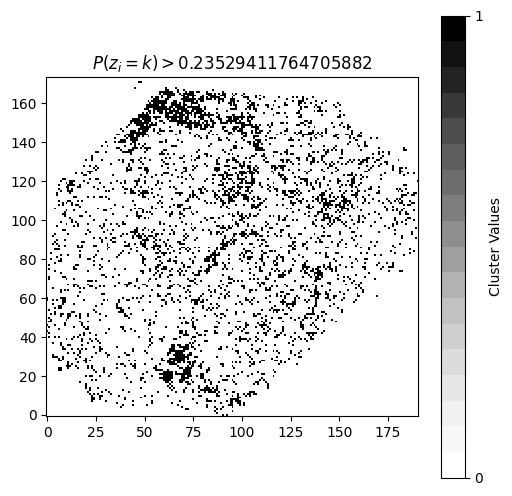

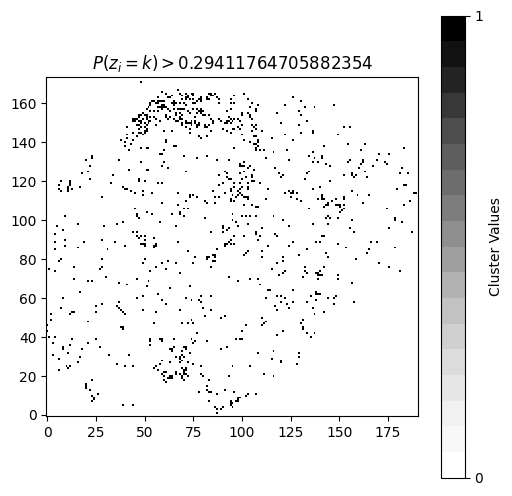

In [14]:
torch.set_default_tensor_type(torch.FloatTensor)

# Grab the learned variational parameters
num_posterior_samples = 100
sample_for_assignment_options = [False, True]

for sample_for_assignment in sample_for_assignment_options:

    cluster_concentration_params_q = pyro.param("cluster_concentration_params_q")
    if sample_for_assignment:
        cluster_probs_q = pyro.sample("cluster_probs", dist.Dirichlet(cluster_concentration_params_q).expand_by([num_posterior_samples])).detach().mean(dim=0)
        # retrieve the relevant prior for comparison
        cluster_probs_prior_TRUE = dist.Dirichlet(concentration_priors).sample()
        cluster_assignments_prior = cluster_probs_prior_TRUE.argmax(dim=1)     
    else:
        # the probs aren't sampled and we calculate the EV instead
        cluster_probs_q = (cluster_concentration_params_q / cluster_concentration_params_q.sum(dim=1, keepdim=True))
        # retrieve the relevant prior for comparison
        cluster_probs_prior_FALSE = (concentration_priors / concentration_priors.sum(dim=1, keepdim=True))
        cluster_assignments_prior = cluster_probs_prior_FALSE.argmax(dim=1)
    cluster_assignments_q = cluster_probs_q.argmax(dim=1)
    
    cluster_concentration_params_q = cluster_concentration_params_q.cpu().detach()
    cluster_means_q = pyro.param("cluster_means_q").cpu().detach()
    cluster_scales_q = pyro.param("cluster_scales_q").cpu().detach()
    cluster_probs_q = cluster_probs_q.cpu().detach()
    cluster_assignments_q = cluster_assignments_q.cpu().detach()
    cluster_assignments_prior = cluster_assignments_prior.cpu().detach()

    # Plotting
    if spot_size:

        rows = spatial_locations["row"].astype(int)
        columns = spatial_locations["col"].astype(int)

        num_rows = max(rows) + 1
        num_cols = max(columns) + 1

        cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

        cluster_grid[rows, columns] = cluster_assignments_q + 1

        colors = plt.cm.get_cmap('viridis', num_clusters + 1)

        colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
        colormap = ListedColormap(colormap_colors)

        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_grid.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
        plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
        plt.title('Posterior Cluster Assignment with BayXenSmooth')

        match data_mode:
            case "PCA":
                data_file_path = f"{data_mode}/{num_pcs}"
            case "HVG": 
                data_file_path = f"{data_mode}/{hvg_var_prop}"
            case "ALL":
                data_file_path = f"{data_mode}"
            case _:
                raise ValueError("The data mode specified is not supported.")

        if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
            os.makedirs(bayxensmooth_clusters_filepath)
        _ = plt.savefig(
            f"{bayxensmooth_clusters_filepath}/result.png"
        )

        clusters = pd.DataFrame(cluster_assignments_q.cpu(), columns=["BayXenSmooth cluster"]).to_csv(f"{bayxensmooth_clusters_filepath}/clusters_K={num_clusters}.csv")
        soft_clusters = pd.DataFrame(cluster_probs_q, columns=[f'P(z_i = {i})'  for i in range(1, num_clusters + 1)]).to_csv(f"{bayxensmooth_clusters_filepath}/soft_clusters_K={num_clusters}.csv")

        if not os.path.exists(bayxensmooth_similar_filepath := save_filepath("BayXenSmooth", "prior_v_posterior", sample_for_assignment)):
            os.makedirs(bayxensmooth_similar_filepath)
        with open(f"{bayxensmooth_similar_filepath}/similarity.txt", 'w') as fp:
            fp.write(str(torch.mean((cluster_assignments_prior == cluster_assignments_q).float()).item()))

        # grab the WSS distance of cluster labels
        wss = {}
        for label in range(1, num_clusters + 1):
            current_cluster_locations = torch.stack(torch.where((cluster_grid.cpu() == label)), axis=1).to(float)
            wss[f"Cluster {label}"] = (spot_size ** 2) * torch.mean(torch.cdist(current_cluster_locations, current_cluster_locations, p = 2)).item()

        if not os.path.exists(bayxensmooth_wss_filepath := save_filepath("BayXenSmooth", "wss", sample_for_assignment)):
            os.makedirs(bayxensmooth_wss_filepath)
        with open(f"{bayxensmooth_wss_filepath}/wss.json", 'w') as fp:
            json.dump(wss, fp)

        cmap = get_cmap('rainbow')

        if isinstance(original_adata.xenium_spot_data.X, csr_matrix):
            labels = np.unique(cluster_assignments_q)  # Define the number of clusters
            gene_columns = original_adata.xenium_spot_data.var.index  # Column names from another source
            mean_expression_by_cluster = pd.DataFrame(columns=gene_columns)

            # Loop through each cluster label
            for label in labels:
                # Find indexes of current cluster
                current_cluster_indexes = torch.where(cluster_assignments_q == label)[0].numpy()
                
                # Efficiently extract the rows for the current cluster using fancy indexing
                expressions = original_adata.xenium_spot_data.X[current_cluster_indexes, :]
                print(label, expressions.shape)
                
                # Compute mean expressions; the result is still a csr_matrix
                mean_expressions = expressions.mean(axis=0)
                
                # Convert mean_expressions to a dense format and then to a DataFrame
                mean_expressions_df = pd.DataFrame(mean_expressions.A, columns=gene_columns)
                
                # Append the result to the mean_expression_by_cluster DataFrame
                mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions_df], ignore_index=True)
        else:
            # identify marker genes within each cluster
            mean_expression_by_cluster = pd.DataFrame(columns=original_adata.xenium_spot_data.var.index)

            for label in range(num_clusters):
                current_cluster_indexes = list(torch.where(cluster_assignments_q == label)[0].cpu().numpy())
                expressions = pd.DataFrame(original_adata.xenium_spot_data.X, columns=original_adata.xenium_spot_data.var.index).iloc[current_cluster_indexes, :]
                mean_expressions = expressions.mean(axis=0).to_frame().T
                mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions], ignore_index=True)

        if evaluate_markers:
            for i, gene in enumerate(mean_expression_by_cluster.columns):
                # using subplots() to draw vertical lines 
                fig, ax = plt.subplots(figsize=(6, 6)) 
                ax.vlines(mean_expression_by_cluster[gene].index, ymin=0, ymax=mean_expression_by_cluster[gene], color=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
                
                # drawing the markers
                ax.plot(mean_expression_by_cluster[gene].index, mean_expression_by_cluster[gene], "^", c=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
                ax.set_ylim(0) 
                
                # formatting and details 
                ax.set_xlabel('Cluster Label') 
                ax.set_ylabel('Mean Expression') 
                ax.set_title(gene) 
                ax.set_xticks(mean_expression_by_cluster[gene].index) 
                if not os.path.exists(bayxensmooth_expression_filepath := save_filepath("BayXenSmooth", "expressions", sample_for_assignment)):
                    os.makedirs(f"{bayxensmooth_expression_filepath}")
                _ = plt.savefig(
                    f"{bayxensmooth_expression_filepath}/GENE={gene}.png"
                )
        
        # confidence mapping
        cluster_confidences = torch.zeros((num_rows, num_cols), dtype=torch.double)

        cluster_confidences[rows, columns] = cluster_probs_q.max(dim=1).values

        colors = plt.cm.get_cmap('Greys', num_clusters + 1)
        colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

        confidence_proportions = {}
        for uncertainty_value in uncertainty_values:
            confidence_matrix = (cluster_confidences > uncertainty_value).float()
            confidence_proportions[uncertainty_value] = torch.mean(confidence_matrix).item()
            plt.figure(figsize=(6, 6))
            plt.imshow(cluster_confidences > uncertainty_value, cmap=colormap, interpolation='nearest', origin='lower')
            plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
            # PLOT ALL UNCERTAINTY VALUESs
            plt.title(r'$P(z_i = k) > $' + f'{uncertainty_value}')
            if not os.path.exists(bayxensmooth_uncertainty_filepath := save_filepath("BayXenSmooth", "uncertainty", sample_for_assignment)):
                os.makedirs(bayxensmooth_uncertainty_filepath)
            _ = plt.savefig(
                f"{bayxensmooth_uncertainty_filepath}/CONFIDENCE={uncertainty_value}.png"
            )

    else:

        plt.scatter(spatial_locations["x_location"], spatial_locations["y_location"], s=1, c=cluster_assignments_q)
        if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
            os.makedirs(bayxensmooth_clusters_filepath)
        _ = plt.savefig(
            f"{bayxensmooth_clusters_filepath}/result.png"
        )
    
    gene_data, spatial_locations, original_adata = prepare_Xenium_data(
        dataset="hBreast", 
        spots=True, 
        spot_size=spot_size, 
        third_dim=False, 
        log_normalize=False, 
        likelihood_mode=data_mode, 
        num_pcs=num_pcs,
        hvg_var_prop=hvg_var_prop,
        min_expressions_per_spot=0
    )

    print("BXS MORAN", sample_for_assignment)
    clusters = pd.DataFrame(cluster_assignments_q.cpu(), columns=["BayXenSmooth cluster"])
    morans_i_gene_dict = gene_morans_i(original_adata, spatial_locations, clusters["BayXenSmooth cluster"])
    # gearys_c_gene_dict = gene_gearys_c(original_adata, spatial_locations, clusters["BayXenSmooth cluster"])
    marker_genes = ["BANK1", "CEACAM6", "FASN", "FGL2", "IL7R", "KRT6B", "POSTN", "TCIM"]
    morans_i_markers = {k: v for k, v in morans_i_gene_dict.items() if k in marker_genes}
    # gearys_c_markers = {k: v for k, v in gearys_c_gene_dict.items() if k in marker_genes}
    print(morans_i_markers)

    print("INITIAL MORAN", sample_for_assignment)
    clusters = pd.DataFrame(initial_clusters, columns=["initial cluster"])
    morans_i_gene_dict = gene_morans_i(original_adata, spatial_locations, clusters["initial cluster"])
    # gearys_c_gene_dict = gene_gearys_c(original_adata, spatial_locations, clusters["BayXenSmooth cluster"])
    marker_genes = ["BANK1", "CEACAM6", "FASN", "FGL2", "IL7R", "KRT6B", "POSTN", "TCIM"]
    morans_i_markers = {k: v for k, v in morans_i_gene_dict.items() if k in marker_genes}
    # gearys_c_markers = {k: v for k, v in gearys_c_gene_dict.items() if k in marker_genes}
    print(morans_i_markers)

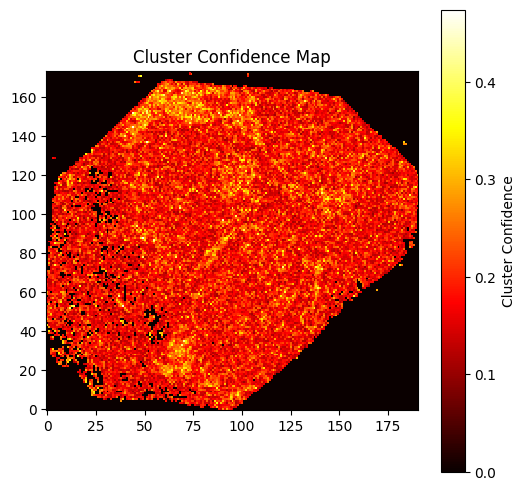

In [15]:
# Plotting the cluster confidences using plt.imshow
plt.figure(figsize=(6, 6))
plt.imshow(cluster_confidences, cmap='hot', interpolation='nearest', origin='lower')
plt.colorbar(label='Cluster Confidence')
plt.title('Cluster Confidence Map')
plt.show()

Text(0.5, 1.0, 'BANK1')

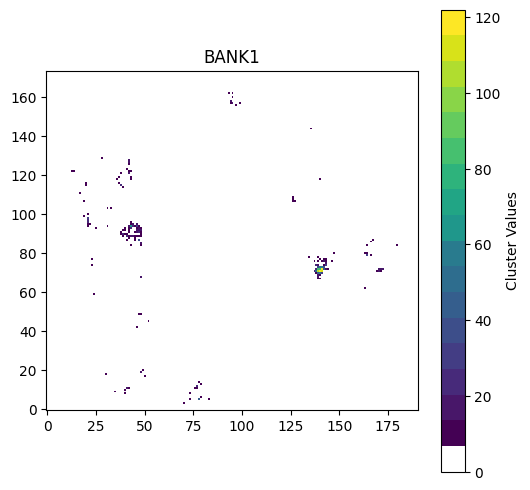

In [16]:
colors = plt.cm.get_cmap('viridis', num_clusters + 1)

colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
colormap = ListedColormap(colormap_colors)

rows = spatial_locations["row"].astype(int)
columns = spatial_locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.double)

GENE_NAME = "BANK1"

cluster_grid[rows, columns] = torch.tensor(original_adata.xenium_spot_data[:, [GENE_NAME]].X).squeeze()

plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
plt.colorbar(label='Cluster Values')
plt.title(GENE_NAME)

Text(0.5, 1.0, 'Posterior Cluster Assignment with BayXenSmooth')

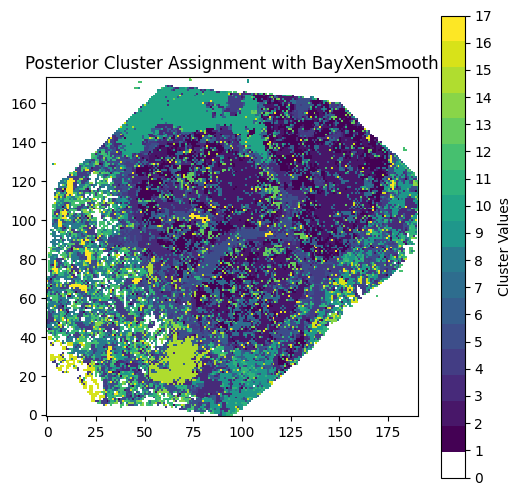

In [17]:
cluster_grid_BXS = torch.zeros((num_rows, num_cols), dtype=torch.long)

cluster_grid_BXS[rows, columns] = cluster_assignments_q + 1

colors = plt.cm.get_cmap('viridis', num_clusters + 1)

colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
colormap = ListedColormap(colormap_colors)

plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid_BXS.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
plt.title('Posterior Cluster Assignment with BayXenSmooth')

In [19]:
cluster_grid_KMeans = torch.zeros((num_rows, num_cols), dtype=torch.int)

cluster_grid_KMeans[rows, columns] = torch.tensor(initial_clusters, dtype=torch.int) + 1

colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
colormap = ListedColormap(colormap_colors)

plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid_KMeans.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
plt.title('K-Means')

ValueError: too many dimensions 'str'

In [20]:
initial_clusters

['11', '7', '7', '7', '3', ..., '7', '8', '13', '11', '11']
Length: 23444
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']

Text(0.5, 1.0, 'Initial Clustering')

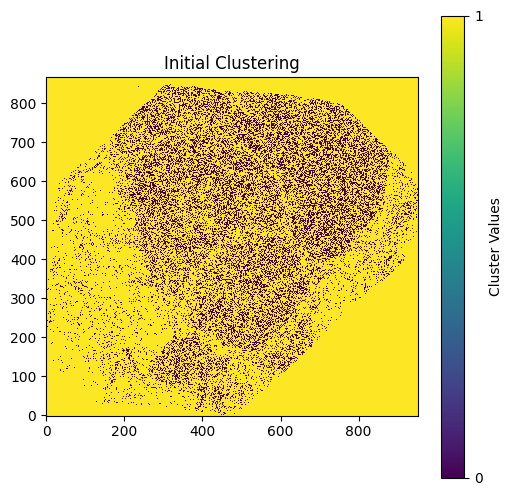

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid_KMeans == cluster_grid_BXS, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
plt.title('Initial Clustering')